# Instalaciones

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from opacus import PrivacyEngine
import matplotlib.pyplot as plt

# Paso 1: Procesamiento de Datos

In [3]:
# Cargar y dividir el conjunto de datos
breast_dataset = load_breast_cancer()
X = breast_dataset.data
y = breast_dataset.target

# Normalizar los datos
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Paso 2: Definir el Modelo

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)
        # No necesitas una capa Sigmoid si usas BCEWithLogitsLoss

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Paso 3: Clase Cliente

In [18]:
class Client:
    def __init__(self, data, target, client_number):
        self.client_number = client_number
        self.model = Net()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCEWithLogitsLoss()
        dataset = TensorDataset(data, target.view(-1, 1))
        self.data_loader = DataLoader(dataset, batch_size=15, shuffle=True)
        self.privacy_engine = PrivacyEngine()  
        self.model, self.optimizer, self.data_loader = self.privacy_engine.make_private_with_epsilon(
            module=self.model,
            optimizer=self.optimizer,
            data_loader=self.data_loader,
            epochs=100,
            target_epsilon=100,
            target_delta=0.001,
            max_grad_norm=1,
        )
          
    def train(self, epochs=5):
        self.model.train()
        results = []  # Lista para almacenar los resultados de cada época
        
        for epoch in range(epochs):
            total_correct = 0
            total_samples = 0
            for data, target in self.data_loader:
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                
                # Calcular el accuracy en los datos de entrenamiento
                pred = torch.sigmoid(output).round()
                correct = pred.eq(target.view_as(pred)).sum().item()
                total_correct += correct
                total_samples += target.size(0)
            
            train_accuracy = total_correct / total_samples  
            epsilon = self.privacy_engine.get_epsilon(delta=0.001)  
            
            # Almacenar los resultados en un diccionario
            results.append({
                'Client': self.client_number,
                'Epoch': epoch+1,
                'Loss': loss.item(),
                'Epsilon': epsilon,
                'Train_ACC': train_accuracy * 100
            })
            
            # Imprimir la información, incluyendo el número del cliente
            print(f"Client: {self.client_number}, Epoch: {epoch+1}, Loss: {loss.item()}, Epsilon: {epsilon}, Train ACC: {train_accuracy * 100:.2f}%")
        
        # Crear un DataFrame y guardar los resultados en un archivo Excel
        df = pd.DataFrame(results)
        df.to_excel(f'Resultados_cliente{self.client_number}.xlsx', index=False)
        
        return self.model.state_dict()
    
    # Método de evaluación  con la data de test para cada cliente
    def evaluate(self, test_data, test_target):
        self.model.eval()
        with torch.no_grad():
            output = self.model(test_data)
            pred = torch.sigmoid(output).round()
            correct = pred.eq(test_target.view_as(pred)).sum().item()
            accuracy = correct / len(test_target)
        return accuracy


# Paso 4: Clase Servidor

In [9]:

class Server:
    def __init__(self):
        self.global_model = Net()

    def aggregate(self, client_models):
        global_dict = {}
        for k in client_models[0].keys():
            adjusted_key = k.replace("_module.", "")  
            global_dict[adjusted_key] = torch.stack([client_models[i][k] for i in range(len(client_models))], 0).mean(0)
        self.global_model.load_state_dict(global_dict)

    def evaluate(self, test_data, test_target):
        self.global_model.eval()  
        with torch.no_grad():
            output_global = self.global_model(test_data)  # y aquí también
            pred_global = torch.sigmoid(output_global).round()
            correct_global = pred_global.eq(test_target.view_as(pred_global)).sum().item()
            accuracy_global = correct_global / len(test_target)
        return accuracy_global


# Paso 5: Entrenamiento y Evaluación

In [64]:
#Entrenamiento y evaluación con la división de prueba para cada cliente:
n_clientes = 3
client_data = torch.chunk(X_train_tensor, n_clientes)
client_target = torch.chunk(y_train_tensor, n_clientes)


clients = [Client(client_data[i], client_target[i], i+1) for i in range(n_clientes)]
client_models = [client.train() for client in clients]
server = Server()
server.aggregate(client_models)

C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter priv

Client: 1, Epoch: 1, Loss: 0.8007652163505554, Epsilon: 7.229711840478823, Train ACC: 37.08%
Client: 1, Epoch: 2, Loss: 0.7512659430503845, Epsilon: 9.618787125042179, Train ACC: 43.45%
Client: 1, Epoch: 3, Loss: 0.6805433630943298, Epsilon: 11.56035669629223, Train ACC: 44.68%
Client: 1, Epoch: 4, Loss: 0.6165859699249268, Epsilon: 13.27581426442283, Train ACC: 45.75%
Client: 1, Epoch: 5, Loss: 0.6320449113845825, Epsilon: 14.848469660834416, Train ACC: 56.74%
Client: 2, Epoch: 1, Loss: 0.6563633680343628, Epsilon: 7.229711840478823, Train ACC: 55.32%
Client: 2, Epoch: 2, Loss: 0.6331483125686646, Epsilon: 9.618787125042179, Train ACC: 70.75%
Client: 2, Epoch: 3, Loss: 0.5735401511192322, Epsilon: 11.56035669629223, Train ACC: 86.71%
Client: 2, Epoch: 4, Loss: 0.5189217329025269, Epsilon: 13.27581426442283, Train ACC: 91.19%
Client: 2, Epoch: 5, Loss: 0.54958176612854, Epsilon: 14.848469660834416, Train ACC: 91.89%
Client: 3, Epoch: 1, Loss: 0.7331064343452454, Epsilon: 7.229711840478

In [65]:
import os

resultados = pd.DataFrame()

for i in range(1,n_clientes+1):
    resultadoxcliente = pd.read_excel(f"Resultados_cliente{i}.xlsx")
    resultados = pd.concat([resultados, resultadoxcliente], ignore_index=True)

In [66]:
resultados

,Client,Epoch,Loss,Epsilon,Train_ACC
0,1,1,0.800765,7.229712,37.078652
1,1,2,0.751266,9.618787,43.448276
2,1,3,0.680543,11.560357,44.680851
3,1,4,0.616586,13.275814,45.751634
4,1,5,0.632045,14.848470,56.741573
5,2,1,0.656363,7.229712,55.319149
6,2,2,0.633148,9.618787,70.748299
7,2,3,0.573540,11.560357,86.708861
8,2,4,0.518922,13.275814,91.194969
9,2,5,0.549582,14.848470,91.891892


In [69]:
import matplotlib.pyplot as plt
def plot_client_metrics(df, title, x_label, y_label, filename, x, y):
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    
    clientss =  range(1,n_clientes+1) # Obtener los clientes únicos
    
    # Iterar sobre cada cliente y trazar sus métricas
    for client in clientss:
        client_data = df[df['Client'] == client]
        plt.plot(client_data[x], client_data[y], marker='o', linestyle='--', linewidth=2, label=f'Client {client}')
        
    plt.xlabel(x_label, fontsize=14)  # Etiqueta del eje x
    plt.ylabel(y_label, fontsize=14)  # Etiqueta del eje y
    plt.title(title, fontsize=16)  # Título del gráfico
    plt.legend(fontsize=12)  # Leyenda
    plt.grid(True, linestyle='--', alpha=0.7)  # Cuadrícula con estilo
    plt.tight_layout()  # Ajuste de diseño
    plt.savefig(filename)  # Guardar el gráfico como imagen
    plt.show()

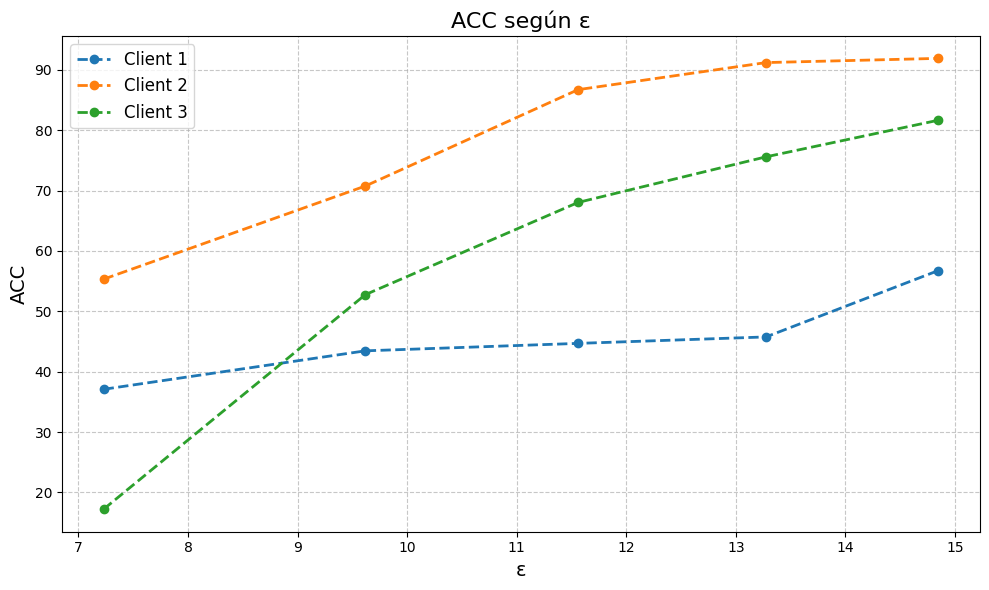

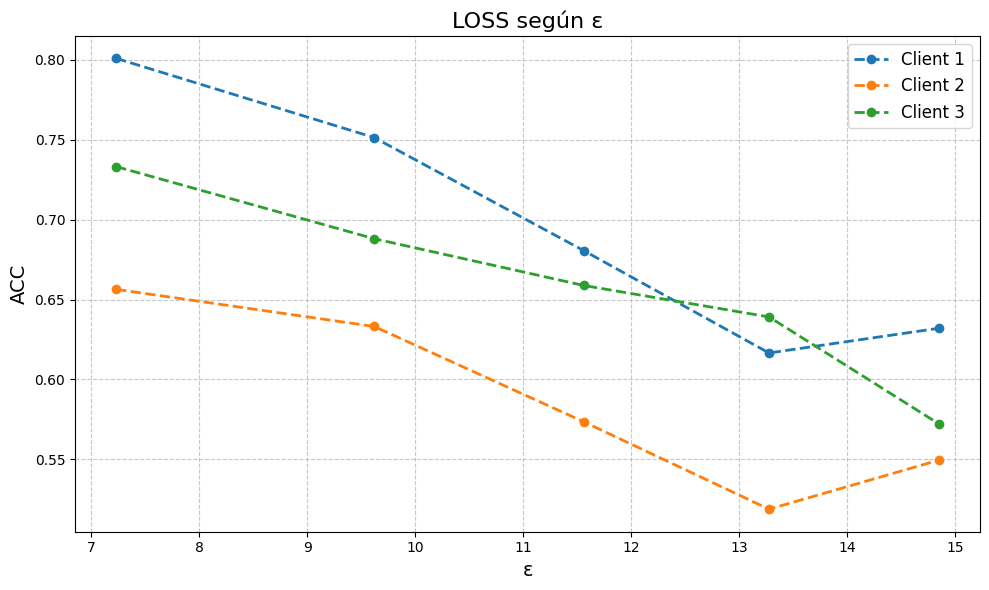

In [70]:
title1="ACC según ε"
title2="LOSS según ε"
x_label="ε"
y_label1="ACC"
y_label2="ACC"
x="Epsilon"
y1="Train_ACC"
y2="Loss"
filename1="plot1.png"
filename2="plot2.png"

plot_client_metrics(resultados, title1, x_label, y_label1, filename1, x, y1)
plot_client_metrics(resultados, title2, x_label, y_label2, filename2, x, y2)


In [71]:
# Evaluación del ACC para cada cliente con la división de entrenamiento
for i in range(3):
    accuracy = clients[i].evaluate(X_test_tensor, y_test_tensor)
    print(f'Accuracy cliente {i+1}: {accuracy * 100:.2f}%')

Accuracy cliente 1: 64.91%
Accuracy cliente 2: 92.11%
Accuracy cliente 3: 81.58%


# Paso 6. Validación del Modelo Global


In [72]:
# Evaluación del ACC del modelo global entrenado con la división de prueba
server = Server()
server.aggregate(client_models)

# Evaluación del modelo global

global_accuracy = server.evaluate(X_test_tensor, y_test_tensor)
print(f'Global model accuracy: {global_accuracy * 100:.2f}%')

Global model accuracy: 83.33%




## ✨ Inspiración

Aunque el código no es exactamente el mismo, este proyecto se inspiró en el innovador trabajo realizado por [Yang, Y., Hui, B., Yuan, H., Gong, N., & Cao, Y. (2023). PrivateFL: Accurate, Differentially Private Federated Learning via Personalized Data Transformation. In Proceedings of the USENIX Security Symposium (Usenix'23)](https://github.com/BHui97/PrivateFL), el cual ofreció valiosas percepciones sobre el aprendizaje federado y la privacidad diferencial. Queremos expresar nuestro agradecimiento a los autores originales y contribuyentes del proyecto que nos inspiró por compartir su conocimiento y recursos con la comunidad de código abierto.

